In [ ]:
#import packages
import torch
from transformers import AutoTokenizer
import random
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

MASK_TOKEN_ID = 126336
tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Instruct", trust_remote_code=True)
vocab_dict = tokenizer.get_vocab()

In [ ]:
#@title Scheduled Sampling
#Defines inverse sigmoid scheduled sampler to transition from uniform masking to priority masking
def sampling_schedule(step, total_steps, schedule_type='inv_sigmoid', k=5.0, t=12000):
    """
    Returns the probability of using the scheduled sampling logic (i.e. get_timestamp with uniform mix)
    """
    if schedule_type == 'linear':
        return max(1 - step / total_steps, 0.0)
    elif schedule_type == 'inv_sigmoid':
        sched_prob = k / (k + np.exp(step / t))
        return k / (k + np.exp(step / t))
    else:
        raise ValueError(f"Unknown schedule type: {schedule_type}")

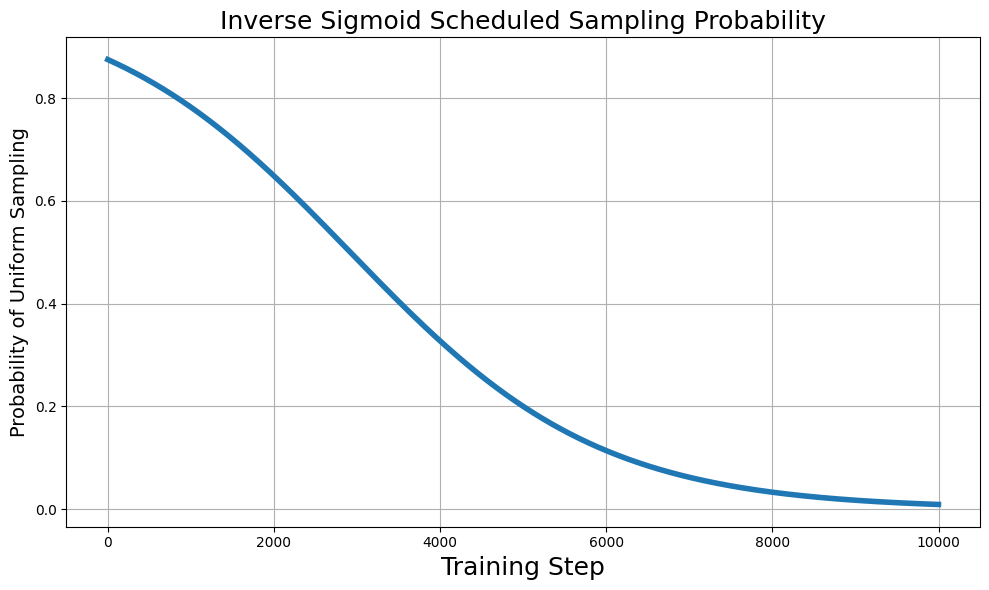

In [ ]:
# Plot of Inverse Sigmoid Schedule used in training
total_steps = 10000
k = 7.0
t = 1500

steps = np.arange(total_steps)
probs = [sampling_schedule(s, total_steps, 'inv_sigmoid', k=k, t=t) for s in steps]

plt.figure(figsize=(10, 6))
plt.plot(steps, probs, label=f'inv_sigmoid (k={k}, t={t})', linewidth=4)
plt.title("Inverse Sigmoid Scheduled Sampling Probability", fontsize=18)
plt.xlabel("Training Step", fontsize=18)
plt.ylabel("Probability of Uniform Sampling", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("inv_sigmoid_schedule.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
#@title Forward Processes
#Uniform Masking Process
def orig_forward_process(input_ids, mask_prob=0.15, mask_token_id=MASK_TOKEN_ID):
    rand = torch.rand_like(input_ids.float()) #randomly generate scores for tokens
    p_mask = rand < mask_prob
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id

    sorted_indices = torch.argsort(rand, dim=1) #identify tokens associated with highest scores
    return noisy_input, p_mask, sorted_indices


mask_prob → avg actual masked fraction
 0.00     → 0.000
 0.05     → 0.046
 0.10     → 0.102
 0.15     → 0.145
 0.20     → 0.204
 0.25     → 0.240
 0.30     → 0.295
 0.35     → 0.344
 0.40     → 0.396
 0.45     → 0.457
 0.50     → 0.507
 0.55     → 0.544
 0.60     → 0.615
 0.65     → 0.658
 0.70     → 0.691
 0.75     → 0.754
 0.80     → 0.792
 0.85     → 0.842
 0.90     → 0.901
 0.95     → 0.951
 1.00     → 1.000


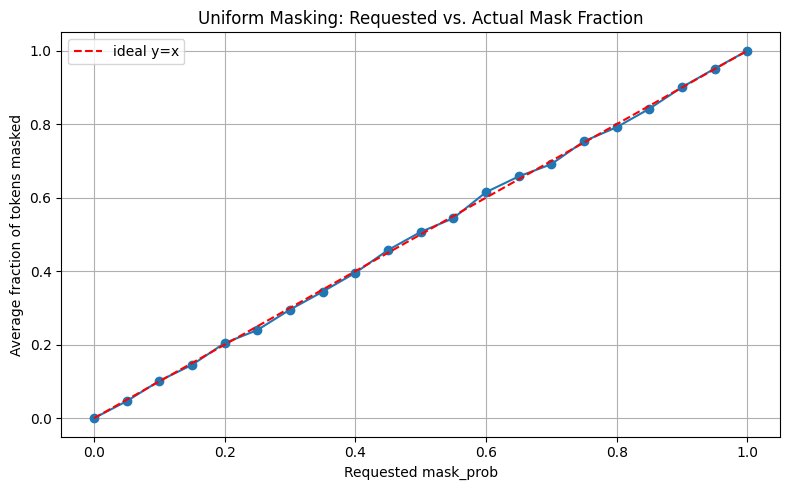

In [ ]:
#Confirmation of Uniform Masking Process
sentence = "The quick brown fox jumped over the lazy dog."
input_ids = tokenizer(sentence, return_tensors="pt").input_ids  # shape (L,)

mask_probs = np.linspace(0.0, 1.0, 21)  # 0.0, 0.05, ..., 1.0
estimates = []

trials = 500

for mp in mask_probs:
    masked_fracs = []
    for _ in range(trials):
        _, p_mask, _ = orig_forward_process(input_ids, mask_prob=mp)
        masked_fracs.append(p_mask.float().mean().item())
    estimates.append(np.mean(masked_fracs))

print("mask_prob → avg actual masked fraction")
for mp, frac in zip(mask_probs, estimates):
    print(f"{mp:5.2f}     → {frac:.3f}")

plt.figure(figsize=(8,5))
plt.plot(mask_probs, estimates, marker='o')
plt.plot([0,1],[0,1], 'r--', label="ideal y=x")
plt.title("Uniform Masking: Requested vs. Actual Mask Fraction")
plt.xlabel("Requested mask_prob")
plt.ylabel("Average fraction of tokens masked")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Priority-based masking
def new_forward_process(input_ids, mask_prob, tokenid_to_priority,
                        mask_token_id=MASK_TOKEN_ID, temperature=0.4, gamma=4.0):
    device = input_ids.device
    token_ids = input_ids.cpu().numpy()
    priorities = tokenid_to_priority[token_ids] #assigns priority scores to tokens

    use_uniform = np.random.rand() < temperature

    if use_uniform: #with probability temperature, do uniform masking
        timestamps = np.random.rand(*token_ids.shape)
    else:
        a = 1 + gamma * priorities
        b = 1 + gamma * (1 - priorities)
        timestamps = beta.rvs(a, b, size=token_ids.shape) #assign order of masking use beta distributional

    sorted_indices = np.argsort(timestamps, axis=1)

    mat_to_mask = np.random.rand(*token_ids.shape)
    num_mask = (mat_to_mask < mask_prob).sum(axis=1)

    B, L = sorted_indices.shape
    row_idx = np.repeat(np.arange(B), num_mask)

    col_idx = np.concatenate([ #efficient way to mask tokens
        sorted_indices[i, :k] for i, k in enumerate(num_mask)
    ])

    mask_flags = np.zeros_like(sorted_indices, dtype=bool)
    mask_flags[row_idx, col_idx] = True

    p_mask = torch.from_numpy(mask_flags).to(device=input_ids.device)
    noisy_input = input_ids.clone()
    noisy_input[p_mask] = mask_token_id

    return noisy_input, p_mask, sorted_indices

In [ ]:
def forward_process(input_ids, mask_prob, step, total_steps, tokenid_to_priority, mask_token_id=MASK_TOKEN_ID, temperature=0.3):
    p = sampling_schedule(step, total_steps)
    if np.random.rand() < p: #scheduled sampling implementation
        noisy_input, p_mask, sorted_indices = orig_forward_process(input_ids, mask_prob, mask_token_id=mask_token_id)
    else:
        noisy_input, p_mask, sorted_indices = new_forward_process(input_ids, mask_prob, tokenid_to_priority, mask_token_id=mask_token_id, temperature=temperature)

    return noisy_input, p_mask, sorted_indices

In [ ]:
def forward_process_answer_only(input_ids, prompt_lengths, mask_prob, step, total_steps, tokenid_to_priority, mask_token_id=MASK_TOKEN_ID, temperature=0.3):
    B, L = input_ids.shape
    device = input_ids.device

    noisy_input = input_ids.clone()
    p_mask = torch.zeros_like(input_ids, dtype=torch.bool)

    for b in range(B):
        prompt_len = prompt_lengths[b].item()
        answer_ids = input_ids[b, prompt_len:]

        # Apply forward_process only on answer part
        noisy_answer, mask_flags, _ = forward_process(
            input_ids=answer_ids.unsqueeze(0),
            mask_prob=mask_prob,
            step=step,
            total_steps=total_steps,
            tokenid_to_priority=tokenid_to_priority,
            mask_token_id=mask_token_id,
            temperature=temperature
        )

        # Replace answer portion with noisy version
        noisy_input[b, prompt_len:] = noisy_answer.squeeze(0)
        p_mask[b, prompt_len:] = mask_flags.squeeze(0)

    return noisy_input, p_mask, None

In [ ]:
#@title Wikipedia IDF Initialization & Comparison with LLaDA Vocab
#LLaDA Vocab Initialization
from transformers import AutoTokenizer
from wordfreq import word_frequency
threshold = 1e-6

tokenizer = AutoTokenizer.from_pretrained("GSAI-ML/LLaDA-8B-Instruct", trust_remote_code=True)
llada_vocab = tokenizer.get_vocab()
llada_tokens = list(llada_vocab.keys())
print("Tokenizer vocab size:", len(llada_vocab))

Tokenizer vocab size: 126349


In [ ]:
llada_tokens_cleaned = llada_tokens
real_words = [
    t for t in llada_tokens_cleaned
    if word_frequency(t, "en") > threshold or word_frequency(t[1:], "en") > threshold
]
non_words = [t for t in llada_tokens_cleaned if t not in real_words]

In [ ]:
#Wikipedia IDF Initialization
import pandas as pd
import random

idf_df = pd.read_csv("wiki_tfidf_terms.csv")
idf_terms = set(str(t).lower() for t in idf_df['token'].dropna())

In [ ]:
# Calculate overlap between llada vocab and wikipedia idf vocab
tokens_in_wiki = [t for t in real_words if t.lower() in idf_terms or t[1:].lower() in idf_terms]
percent_overlap = 100 * len(tokens_in_wiki) / len(real_words)

print(f"LLaDA real English vocab tokens total        : {len(real_words)}")
print(f"Tokens found in wiki_tfidf     : {len(tokens_in_wiki)}")
print(f"Percentage of LLaDA real English vocab in wiki IDF set: {percent_overlap:.2f}%")

tokens_not_in_wiki = [t for t in real_words if t not in tokens_in_wiki]

LLaDA real English vocab tokens total        : 54872
Tokens found in wiki_tfidf     : 54238
Percentage of LLaDA real English vocab in wiki IDF set: 98.84%


In [ ]:
print("\nSample of LLaDA real English vocab tokens in Wikipedia TF-IDF set:")
print(random.sample(tokens_in_wiki, 10))

print("\nSample of LLaDA real English vocab tokens NOT found in Wikipedia TF-IDF set:")
print(random.sample(tokens_not_in_wiki, 10))


Sample of LLaDA real English vocab tokens in Wikipedia TF-IDF set:
['compiler', 'Ġvacuum', '_strings', '.double', 'Ġdark', 'BBB', 'MIC', 'ĠDefense', 'Ġdangerously', 'Ġquestionnaires']

Sample of LLaDA real English vocab tokens NOT found in Wikipedia TF-IDF set:
['_,', 'ç©', 'Ã¼n', 'Ã¤m', 'Î¦', 'Ã©', 'è®¹', 'Ġnull', 'Ã¼ss', 'å·©']


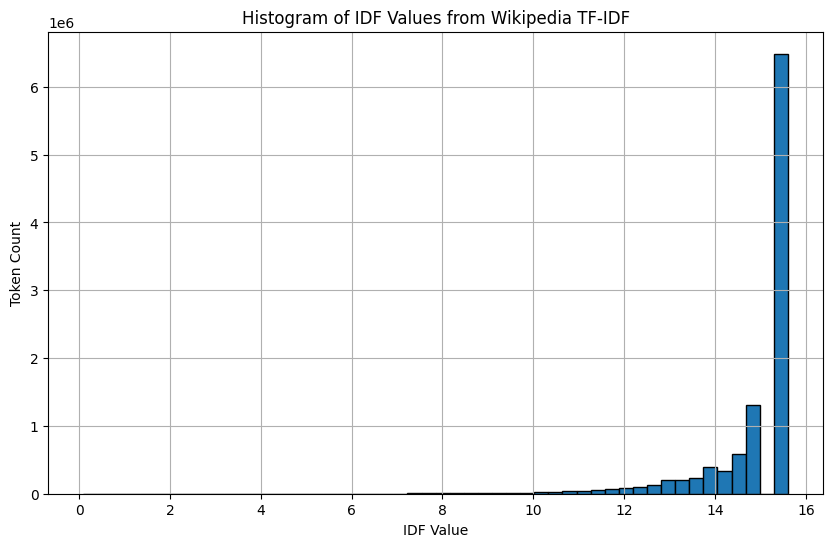

In [ ]:
idf_values = idf_df['idf'].dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(idf_values, bins=50, edgecolor='black')
plt.title('Histogram of IDF Values from Wikipedia TF-IDF')
plt.xlabel('IDF Value')
plt.ylabel('Token Count')
plt.grid(True)
plt.show()

/tmp/ipykernel_1716891/3493015237.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_real['idf_norm'] = (idf_real['idf'] - idf_min) / (idf_max - idf_min)


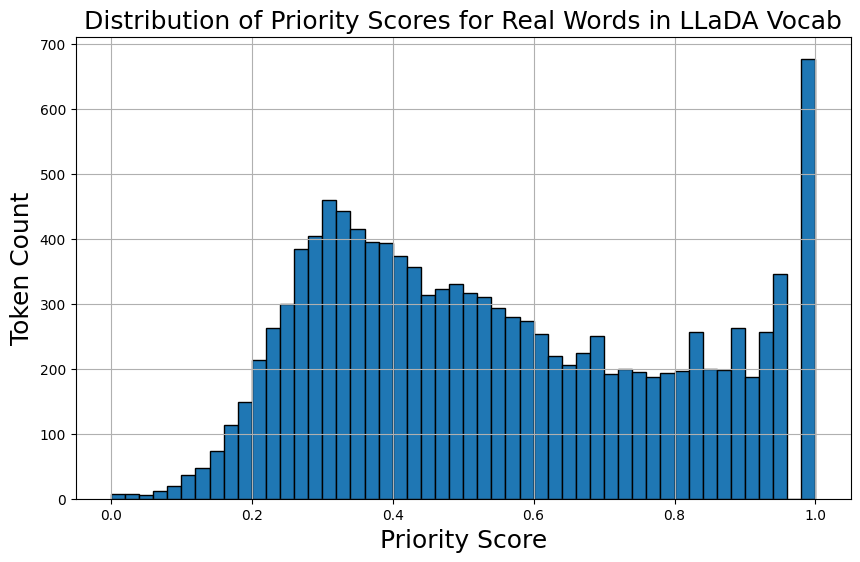

In [ ]:
#@title Creating Scores From IDF
import matplotlib.pyplot as plt

real_words_lower = set(t.lower() for t in real_words)

idf_real = idf_df[idf_df['token'].str.lower().isin(real_words_lower)]
idf_min = min(idf_real['idf'])
idf_max = max(idf_real['idf'])

idf_real['idf_norm'] = (idf_real['idf'] - idf_min) / (idf_max - idf_min)
idf_df['idf_norm'] = (idf_df['idf'] - idf_min) / (idf_max - idf_min)
idf_real_values = idf_real['idf_norm'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(idf_real_values, bins=50, edgecolor='black')
plt.title('Distribution of Priority Scores for Real Words in LLaDA Vocab', fontsize = 18)
plt.xlabel('Priority Score', fontsize = 18)
plt.ylabel('Token Count', fontsize = 18)
plt.grid(True)
plt.savefig("priority_dist.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
print("\nDescriptive stats for IDF values of real_words:")
print(idf_real_values.describe())
mean_idf_norm = idf_real_values.mean()


Descriptive stats for IDF values of real_words:
count    12011.000000
mean         0.550622
std          0.246118
min          0.000000
25%          0.343003
50%          0.509629
75%          0.754607
max          1.000000
Name: idf_norm, dtype: float64


In [ ]:
#Sample tokens as IDF varies
idf_0_to_3 = idf_df[(idf_df['idf'] >= 0) & (idf_df['idf'] < 3)]

print(f"Number of tokens with 0 ≤ IDF < 3: {len(idf_0_to_3)}")
print("\nSample tokens with IDF between 0 and 3:")
print(idf_0_to_3[['token', 'idf']].sample(5).to_string(index=False))

idf_6_to_9 = idf_df[(idf_df['idf'] >= 6) & (idf_df['idf'] < 9)]

print(f"Number of tokens with 6 ≤ IDF < 9: {len(idf_6_to_9)}")
print("\nSample tokens with IDF between 6 and 9:")
print(idf_6_to_9[['token', 'idf']].sample(5).to_string(index=False))

idf_13_to_16 = idf_df[(idf_df['idf'] >= 13) & (idf_df['idf'] < 16)]

print(f"Number of tokens with 13 ≤ IDF < 16: {len(idf_13_to_16)}")
print("\nSample tokens with IDF between 13 and 16:")
print(idf_13_to_16[['token', 'idf']].sample(5).to_string(index=False))


Number of tokens with 0 ≤ IDF < 3: 405

Sample tokens with IDF between 0 and 3:
 token      idf
     2 2.311493
though 2.857211
  most 1.753201
worked 2.695704
others 2.880855
Number of tokens with 6 ≤ IDF < 9: 45893

Sample tokens with IDF between 6 and 9:
      token      idf
   finances 6.153787
   vignette 8.837089
     denote 6.433878
       laos 6.688942
unconnected 8.015235
Number of tokens with 13 ≤ IDF < 16: 9639135

Sample tokens with IDF between 13 and 16:
      token       idf
neelamratna 15.605582
     11/70s 15.605582
  gaugerici 15.605582
doskonałość 14.912435
      gjein 15.605582


In [ ]:
#Creates priority score dict using normalized IDF, set default to the mean value
idf_dict = {
    (token, token_id): mean_idf_norm
    for token, token_id in vocab_dict.items()
}

In [ ]:
#fast lookup
idf_lookup = {
    str(row['token']): row['idf_norm']
    for _, row in idf_df.dropna(subset=['token', 'idf_norm']).iterrows()
}
print("Lookup Complete")

Lookup Complete


In [ ]:
#assigns direct matches in the vocabs to the correct idf
for (token, token_id), idf_val in idf_dict.items():
    if token in idf_lookup:
        idf_dict[(token, token_id)] = idf_lookup[token]

In [ ]:
for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm and len(token) > 1:
        token_dropped = token[1:]
        if token_dropped in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_dropped]

In [ ]:
#as many tokens in the llada vocab have a Ġ prefix for space, e.g. " dog" becomes "Ġdog"
#and the wikipedia idf dataset also misses different capitalizations we assign all
#"variants" to the same idf for better coverage, so Ġdog would have the same idf as dog
for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm:
        token_lower = token.lower()
        if token_lower in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_lower]

for (token, token_id), idf_val in idf_dict.items():
    if idf_val == mean_idf_norm and len(token) > 1:
        token_dropped_lower = token[1:].lower()
        if token_dropped_lower in idf_lookup:
            idf_dict[(token, token_id)] = idf_lookup[token_dropped_lower]

In [ ]:
sampled_entries = random.sample(list(idf_dict.items()), 10)
print("Sample entries from idf_dict:")
for (token, token_id), idf_val in sampled_entries:
    print(f"Token: {token:20s} | ID: {token_id:6d} | Normalized IDF: {idf_val:.4f}")

Sample entries from idf_dict:
Token: ï¼ĮåĢ¡å¯¼            | ID: 124106 | Normalized IDF: 0.5506
Token: ells                 | ID:  10756 | Normalized IDF: 0.6123
Token: æĬĢæľ¯æĸ¹æ¡Ī         | ID:  27940 | Normalized IDF: 0.5506
Token: Ġstrife              | ID: 120928 | Normalized IDF: 0.4518
Token: ä»İå¤ĸéĿ¢            | ID: 114557 | Normalized IDF: 0.5506
Token: ãĤĬ                  | ID:  22803 | Normalized IDF: 0.5506
Token: Â·ç§ĳ                | ID: 106222 | Normalized IDF: 0.5506
Token: Ġconce               | ID:  24154 | Normalized IDF: 0.8962
Token: å¸ĺ                  | ID:  19327 | Normalized IDF: 0.5506
Token: Ġdiscard             | ID:  53369 | Normalized IDF: 0.5091


In [ ]:
#We see that many words have a corresponding idf in wikipedia idf
#dictionary. There are ~70k tokens with non-default entries, but
#the bulk aren't english tokens
non_default_count = sum(
    1 for v in idf_dict.values() if v != mean_idf_norm
)
total_count = len(idf_dict)
coverage = 100 * non_default_count / total_count

print(f"Total entries         : {total_count}")
print(f"Non-default entries   : {non_default_count}")
print(f"Default entries       : {total_count - non_default_count}")
print(f"Coverage              : {coverage:.2f}%")


Total entries         : 126349
Non-default entries   : 68566
Default entries       : 57783
Coverage              : 54.27%


In [ ]:
def build_tokenid_to_priority(vocab_dict, dict, default_priority=0.5):
    max_id = max(vocab_dict.values()) + 1
    table = np.full(max_id, default_priority)
    for (_, token_id), priority in dict.items():
        table[token_id] = priority
    return table

tokenid_to_priority = build_tokenid_to_priority(vocab_dict, idf_dict)

Token priorities:
The          → 0.067
Ġquick       → 0.325
Ġbrown       → 0.239
Ġfox         → 0.294
Ġjumped      → 0.388
Ġover        → 0.104
Ġthe         → 0.000
Ġlazy        → 0.447
Ġdog         → 0.314
Ġto          → 0.017
Ġtalk        → 0.284
Ġto          → 0.017
ĠAustin      → 0.325
's           → 0.047
Ġfriendly    → 0.299
Ġfeline      → 0.546
Ġcat         → 0.348
.            → 0.551


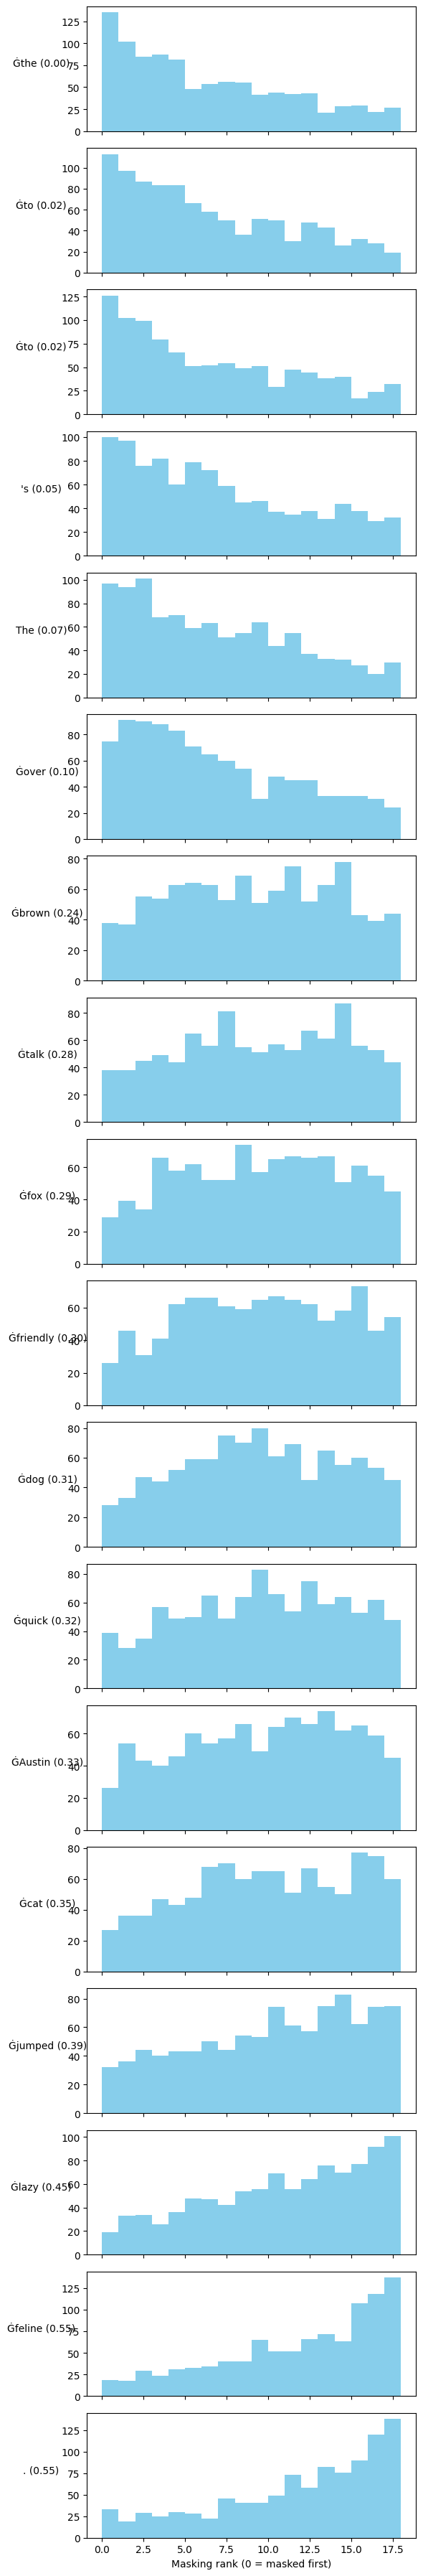


Masked sequences:
mask_prob=0.00: The quick brown fox jumped over the lazy dog to talk to Austin's friendly feline cat.
mask_prob=0.10: The quick brown fox jumped over the lazy dog<|mdm_mask|> talk to Austin's friendly feline cat.
mask_prob=0.20: <|mdm_mask|><|mdm_mask|> brown fox jumped over the lazy dog to talk<|mdm_mask|> Austin's friendly feline cat.
mask_prob=0.30: The quick brown fox jumped over the lazy dog<|mdm_mask|> talk<|mdm_mask|> Austin<|mdm_mask|><|mdm_mask|> feline<|mdm_mask|>.
mask_prob=0.40: The<|mdm_mask|><|mdm_mask|> fox jumped<|mdm_mask|><|mdm_mask|> lazy dog to talk<|mdm_mask|> Austin<|mdm_mask|> friendly feline<|mdm_mask|>.
mask_prob=0.50: <|mdm_mask|> quick<|mdm_mask|><|mdm_mask|> jumped<|mdm_mask|> the lazy dog<|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> friendly feline cat.
mask_prob=0.60: <|mdm_mask|><|mdm_mask|> brown<|mdm_mask|> jumped<|mdm_mask|> the lazy dog<|mdm_mask|> talk to<|mdm_mask|><|mdm_mask|><|mdm_mask|><|mdm_mask|> cat<|mdm_mask|

In [ ]:
#@title Example of Priority-Guided Masking
sentence = "The quick brown fox jumped over the lazy dog to talk to Austin's friendly feline cat."
inputs = tokenizer(sentence, return_tensors="pt")
input_ids = inputs.input_ids  # shape: (1, sequence_length)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokenid_to_priority = build_tokenid_to_priority(vocab_dict, idf_dict)

print("Token priorities:")
token_ids = input_ids[0].tolist()
priorities = [tokenid_to_priority[tid] for tid in token_ids]
sorted_token_indices = sorted(range(len(tokens)), key=lambda i: priorities[i])
for tok, tid in zip(tokens, input_ids[0].tolist()):
    print(f"{tok:12s} → {tokenid_to_priority[tid]:.3f}")

mask_prob = 0.5
step = 60000
total_steps = 60000
trials = 1000
ranks = {i: [] for i in range(len(tokens))}

for _ in range(trials):
    noisy_input, p_mask, sorted_indices = new_forward_process(input_ids, mask_prob, tokenid_to_priority, temperature=0.4)
    # sorted_idx[0] records the ranking for the single batch entry
    sorted_idx = np.argsort(sorted_indices[0])
    for pos in range(len(tokens)):
        ranks[pos].append(sorted_idx[pos])

# Get priorities for each token position
token_ids = input_ids[0].tolist()
priorities = [tokenid_to_priority[tid] for tid in token_ids]
sorted_indices = sorted(range(len(tokens)), key=lambda i: priorities[i])

# Plot in sorted priority order
fig, axes = plt.subplots(len(tokens), 1, figsize=(6, 2 * len(tokens)), sharex=True)
for plot_idx, token_idx in enumerate(sorted_indices):
    ax = axes[plot_idx]
    ax.hist(ranks[token_idx], bins=len(tokens), range=(0, len(tokens)), color='skyblue')
    label = f"{tokens[token_idx]} ({priorities[token_idx]:.2f})"
    ax.set_ylabel(label, rotation=0, labelpad=20)
axes[-1].set_xlabel("Masking rank (0 = masked first)")
plt.tight_layout()
plt.show()

def new_forward_and_mask(input_ids, mask_prob,
                         tokenid_to_priority, mask_token_id, temperature, gamma):
    device = input_ids.device
    # Ensure token_ids is 2D (batch size 1, sequence length)
    token_ids = input_ids.cpu().numpy()
    priorities = tokenid_to_priority[token_ids]
    use_uniform = np.random.rand() < temperature
    if use_uniform:
        timestamps = np.random.rand(*token_ids.shape)
    else:
        a = 1 + gamma * priorities
        b = 1 + gamma * (1 - priorities)
        timestamps = beta.rvs(a, b, size=token_ids.shape)
    k = int(mask_prob * token_ids.shape[1])
    sorted_idx = np.argsort(timestamps, axis=1)[0]
    mask = np.zeros_like(token_ids, dtype=bool)
    mask[0, sorted_idx[:k]] = True
    p_mask = torch.from_numpy(mask).to(device=input_ids.device)
    noisy = input_ids.clone()
    noisy[p_mask] = mask_token_id
    return noisy, p_mask

print("\nMasked sequences:")
for mp in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    noisy, _ = new_forward_and_mask(input_ids, mp,
                                    tokenid_to_priority, MASK_TOKEN_ID, 0.4, 4.0)
    print(f"mask_prob={mp:.2f}: {tokenizer.decode(noisy[0])}")

print("\nAverage masking rank per token:")
for token_idx in sorted_token_indices:
    avg_rank = np.mean(ranks[token_idx])
    print(f"{tokens[token_idx]:12s} → priority={priorities[token_idx]:.3f}, avg_rank={avg_rank:.2f}")
